In [1]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Grayscale, ToPILImage
#import onnx
#from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
#from onnx2pytorch import ConvertModel

# Auxiliary Python imports
import numpy as np
import pickle as pkl
import bz2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple

## Gym imports
import gym
import gym_jumping_task

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Testing the environment

In [3]:
gym.make('jumping-task-v0')
env = gym_jumping_task.envs.JumpTaskEnv()
ACTION_SPACE = env.nb_actions
floor_height = 10
obstacle_pos = 30
state = env._reset(floor_height=floor_height, obstacle_position=obstacle_pos)

c:\Users\Sarrg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (60, 60)
  logger.warn(


In [4]:
print(state.shape)

(60, 60)


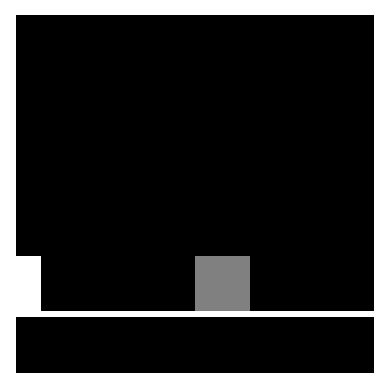

In [5]:
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')

## Define Expert policy

In [6]:
class Expert():
    def __init__(self, env: gym_jumping_task.envs.JumpTaskEnv):
        self.env = env
    
    def select_action(self, state=None):
        if self.env.agent_pos_x + 14 == self.env.obstacle_position:
            return 1
        return 0

Score: 57
Game Won


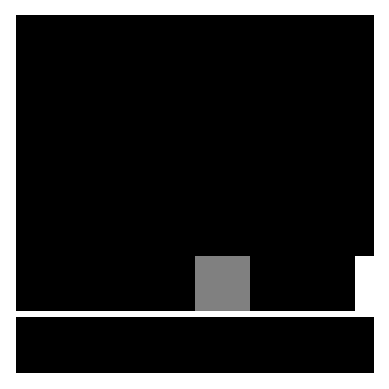

In [7]:
env.reset()
expert = Expert(env)
done = False
score = 0
while not done:
    a = expert.select_action()
    state, reward, done, _ = env.step(a)
    score += reward
print("Score:", score)
print("Game", "Won" if reward == 2 else "Lost")
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')
plt.show()

## Generate and store demonstrations played by the expert

In [9]:
#Transition = namedtuple('Transition', ['state', 'action', 'rewards', 'next_state', 'done'])
Transition = namedtuple('Transition', ['state', 'action'])

class Episode(object):
    def __init__(self):
        self.transitions = []
        
    def __len__(self):
        return len(self.transitions)
    
    def append(self, transition):
        self.transition.append(transition)
        
    def __getitem__(self, index):
        return self.transitions[index]


class ReplayBuffer(object):
    def __init__(self, capacity=0):
        self.buffer = []
        self._next = 0
        self.capacity = capacity
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def add(self, episode):
        if self.capacity != 0 and len(self) == self.capacity:
            self.buffer[self._next] = episode
            self._next = (self._next+1)%self.capacity
        else:
            self.buffer.extend(episode)
        
    def save(self, path):
        with bz2.open(path, "wb") as f:
            f.write(pkl.dumps(self.buffer))
    
    def load(self, path):
        with bz2.open(path, "rb") as f:
            self.buffer = pkl.loads(f.read())
        


In [13]:
n_episodes = 250

env = gym_jumping_task.envs.JumpTaskEnv()
expert = Expert(env)
buffer = ReplayBuffer()
for e in tqdm(range(n_episodes)):
    episode = []
    env.reset()
    done = False
    while not done:
        a = expert.select_action()
        episode.append(Transition(state, a))
        state, reward, done, _ = env.step(a)
    if reward == -1:
        print("[WARN] GAME LOST")
    buffer.add(episode)
buffer.save("demonstrations.bz2")
print("Transitions:", len(buffer))

  0%|          | 0/250 [00:00<?, ?it/s]

Transitions: 14000


## Load Demonstrations and create Dataset

In [14]:
buffer = ReplayBuffer()
buffer.load("demonstrations.bz2")
print("Transitions:", len(buffer))

Transitions: 14000


In [44]:
class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        sample = self.buffer[index]
        state = torch.tensor(sample.state).unsqueeze(dim=0)
        _action = sample.action
        action = torch.zeros(ACTION_SPACE)
        action[_action] = 1.0
        return state.to(device), action.to(device)

In [45]:
dataset = BufferDataset(buffer)
print(dataset.__getitem__(0))

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor([1., 0.]))


## Define Agent and Policy Network

In [46]:
class AgentNetwork(nn.Module):
    def __init__(self, n_action_space):
        super(AgentNetwork, self).__init__()
        
        # based on LeNet
        self.c1 = torch.nn.Conv2d(1, 6, 5)
        self.s2 = torch.nn.MaxPool2d(4)
        self.c3 = torch.nn.Conv2d(6, 16, 5)
        self.s4 = torch.nn.MaxPool2d(2)
        self.c5 = torch.nn.Conv2d(16, 120, 5)
        self.f6 = torch.nn.Linear(120, n_action_space*5)
        self.d7 = torch.nn.Dropout(0.5)
        self.out = torch.nn.Linear(n_action_space*5, n_action_space)

    def forward(self, x):
        x = torch.relu(self.c1(x))
        x = self.s2(x)
        x = torch.relu(self.c3(x))
        x = self.s4(x)
        x = torch.relu(self.c5(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.f6(x))
        x = self.d7(x)
        return self.out(x)

class Agent():
    def __init__(self, model):
        self.model = model
        pass
    
    @staticmethod
    def transform(state):
        return torch.tensor(state).unsqueeze(0).unsqueeze(0)
    
    @torch.no_grad()
    def act(self, state):
        self.model.eval()
        state = self.transform(state)
        actions = self.model(state).squeeze()
        return torch.argmax(actions).item()

## Training the Agent

In [47]:
class BCTrainer(object):
    """Behavioral Cloning Trainer class
    """
    
    def __init__(self, model, dataloader, loss_func, optimizer):
        self.model = model
        self.dataloader = dataloader
        self.loss_func = loss_func
        self.optimizer = optimizer
        
    def train(self, pbar=None):
        self.model.train()
        if pbar is None:
            pbar = tqdm(range(1))
        
        losses = []
        loader_len = len(self.dataloader)
        for i, (states, actions) in enumerate(self.dataloader):
            pred = self.model(states)
            loss = self.loss_func(pred, actions)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_postfix_str(f"[{i+1}/{loader_len}] Loss: {losses[-1]:.4f}")
        
        return losses
    
    def eval(self):
        self.model.eval()
        losses = []
        loader_len = len(self.dataloader)
        for i, (states, actions) in enumerate(self.dataloader):
            pred = self.model(states)
            loss = self.loss_func(pred, actions)
            losses.append(loss.item())
        
        return losses
        
            
    def run(self, epochs):
        avg_losses = np.zeros(epochs+1)
        avg_losses[0] = np.mean(self.eval())
        with tqdm(range(1, epochs+1)) as pbar:
            for e in pbar:
                losses = self.train(pbar)
                avg_losses[e] = np.mean(losses)
        return avg_losses

In [48]:
lr = 1e-3
batchsize = 250
n_epochs = 10

In [49]:
np.random.seed(8)
torch.manual_seed(8)

net = AgentNetwork(ACTION_SPACE).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

trainer = BCTrainer(net, loader, loss_func, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

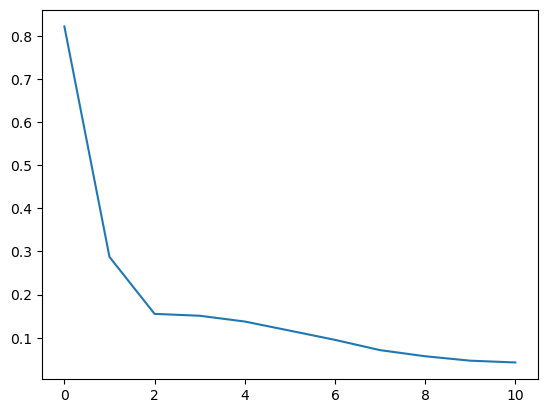

In [50]:
losses = trainer.run(n_epochs)
plt.plot(losses)

## Evaluation of Behavioral Cloning Agent

In [38]:
def evaluate(env, agent, n_episodes=50):
    won = 0
    with tqdm(range(n_episodes)) as pbar:
        for e in pbar:
            state = env.reset()
            done = False
            while not done:
                a = agent.act(state)
                state, reward, done, _ = env.step(a)

            if reward == 2:
                won += 1
            pbar.set_postfix_str(f"Won: {won}/{n_episodes}")
    env.close()
    return won / n_episodes

#### Evaluate on different seed

In [39]:
n_episodes = 100
env = gym_jumping_task.envs.JumpTaskEnv(rendering=True, seed=8)
agent = Agent(net)
wl_ratio = evaluate(env, agent, n_episodes)
print(f"{wl_ratio*100}% of games won")

  0%|          | 0/100 [00:00<?, ?it/s]

100.0% of games won
